* extração de dados do Google Trends
* leitura dos dados da B3
    - ano de 2021 (último ano disponível)
    - BOVA11
    - pesquisa de palavras IBOVESPA, IBOV e BOVA11

## 1. dados do google trends

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
pd.set_option('display.max_columns', 0)

#### buscando dados armazenados no servidor dos EUA (hl = 'en-US')

In [2]:
pytrends = TrendReq(hl = 'en-US', tz = 360)

# lista de palavras a serem pesquisadas
kw_list = ['IBOV', 'IBOVESPA', 'BOVA11']

os parâmetros são:
* lista de palavras
* categoria (0 = todas)
* período de tempo (é possível especificar um período de data: timeframe = '2022-01-01 2022-06-01' para 01/jan até 01/jun)
* região geográfica (se ficar em branco é mundial)
* tipo de dados (pode ser 'images', 'news', 'youtube')

In [3]:
pytrends.build_payload(kw_list, cat = 0, timeframe = '2021-01-01 2021-12-31', geo = 'BR', gprop = '')

# retorna um dataframe pandas
palavras_trend = pytrends.interest_over_time()

del palavras_trend['isPartial']

In [4]:
# amostra
palavras_trend.head()

,IBOV,IBOVESPA,BOVA11
date,,,
2021-01-03,14,94,5
2021-01-10,12,79,4
2021-01-17,12,86,3
2021-01-24,12,77,3
2021-01-31,11,79,3


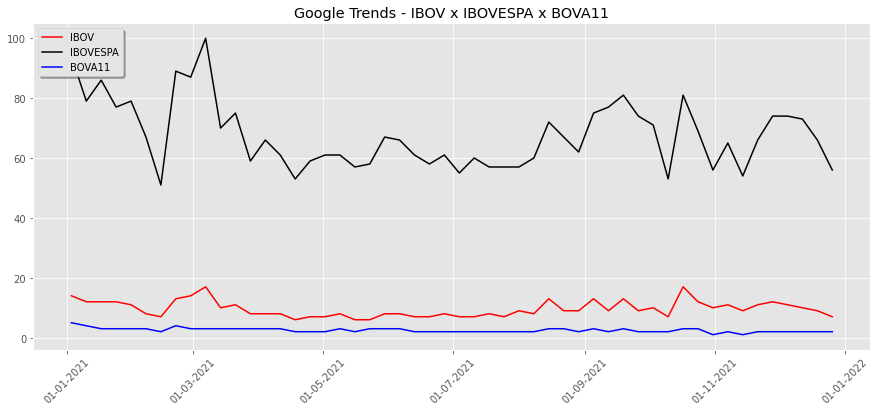

In [5]:
# gráfico de tendência das palavras pesquisadas
plt.style.use('ggplot')
fig = plt.figure(figsize = (15, 6))
ax1 = plt.subplot(111)
plt.title('Google Trends - IBOV x IBOVESPA x BOVA11')

ax1.plot(palavras_trend[kw_list[0]], '-r', palavras_trend[kw_list[1]], '-k', palavras_trend[kw_list[2]], '-b')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(ax1.get_xticklabels(), rotation = 45)

plt.legend((kw_list[0], kw_list[1], kw_list[2]), loc = 'upper left', shadow = True)

In [6]:
# padronizando os dados
min_max_scaler = MinMaxScaler()

palavras_trend[["IBOV", "IBOVESPA", "BOVA11"]] = min_max_scaler.fit_transform(palavras_trend[["IBOV", "IBOVESPA", "BOVA11"]])

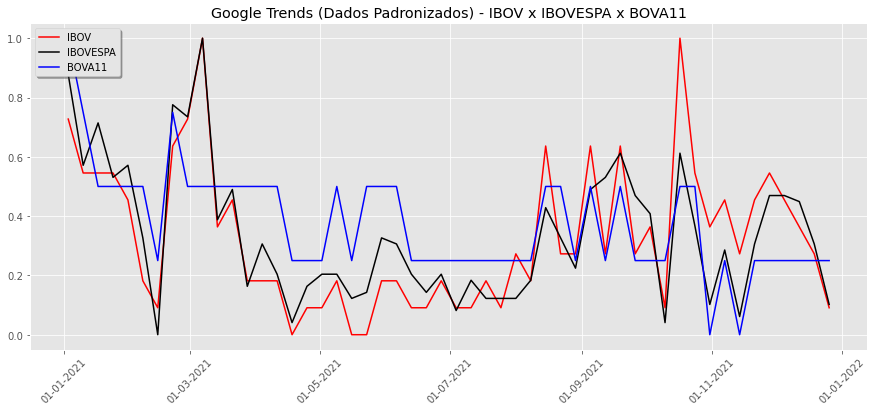

In [7]:
# gráfico de tendência das palavras pesquisadas
plt.style.use('ggplot')
fig = plt.figure(figsize = (15, 6))
ax1 = plt.subplot(111)
plt.title('Google Trends (Dados Padronizados) - IBOV x IBOVESPA x BOVA11')

ax1.plot(palavras_trend[kw_list[0]], '-r', palavras_trend[kw_list[1]], '-k', palavras_trend[kw_list[2]], '-b')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(ax1.get_xticklabels(), rotation = 45)

plt.legend((kw_list[0], kw_list[1], kw_list[2]), loc = 'upper left', shadow = True)

## 2. dados da B3

In [8]:
# leitura do arquivo - dados diários de 2021
arquivo_b3 = './dados_b3/COTAHIST_A2021.txt'

# com base no layout disponibilizado pela B3
tamanho_campos = [2 ,8, 2, 12, 3, 12, 10, 3, 4, 13, 13, 13, 13, 13, 13, 13, 5, 18, 18, 13, 1, 8, 7, 13, 12, 3]

# dataframe pandas
dados_b3 = pd.read_fwf(arquivo_b3, widths = tamanho_campos)

In [9]:
# nomear colunas
dados_b3.columns = ['tipo_registro', 'data_pregao', 'cod_bdi', 'ticker', 'tipo_mercado', 'empresa', 
                    'especificacao_papel', 'prazo_dias_merc_termo', 'moeda_referencia', 'preco_abertura', 'preco_max', 
                    'preco_min', 'preco_medio', 'preco_ultimo_negocio', 'preco_melhor_oferta_compra', 
                    'preco_melhor_oferta_venda', 'qtd_negocios', 'qtd_papeis_negociados', 'vol_total_negociado', 
                    'preco_exercicio', 'ìndicador_correcao_precos', 'data_vencimento' , 'fator_cotacao', 
                    'preco_exercicio_pontos', 'cod_isin', 'num_distribuicao_papel']

# eliminar trailer do arquivo
linha = len(dados_b3['data_pregao'])
dados_b3 = dados_b3.drop(linha-1)

# alterar tipo da data
dados_b3['data_pregao'] = pd.to_datetime(dados_b3['data_pregao'], format='%Y/%m/%d')
dados_b3.set_index('data_pregao', inplace = True)

# ajustar valores para decimal
lista_dec = ['preco_abertura', 'preco_max', 'preco_min', 'preco_medio', 'preco_ultimo_negocio', 'preco_melhor_oferta_compra', 
           'preco_melhor_oferta_venda', 'vol_total_negociado', 'preco_exercicio', 'preco_exercicio_pontos']

for coluna in lista_dec:
    dados_b3[coluna]=[i/100. for i in dados_b3[coluna]]

In [10]:
# amostra
dados_b3.head()

,tipo_registro,cod_bdi,ticker,tipo_mercado,empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,preco_max,preco_min,preco_medio,preco_ultimo_negocio,preco_melhor_oferta_compra,preco_melhor_oferta_venda,qtd_negocios,qtd_papeis_negociados,vol_total_negociado,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,cod_isin,num_distribuicao_papel
data_pregao,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,1,2.0,A1AP34,10,ADVANCE AUTO,DRN,NaN,R$,51.10,52.03,50.62,51.91,51.90,51.80,61.32,22.0,6420.0,333558.7,0.0,0.0,99991231.0,1.0,0.0,BRA1APBDR001,105.0
2021-01-04,1,2.0,A1BB34,10,ABB LTD,DRN,NaN,R$,36.80,37.32,36.74,37.01,37.18,37.29,0.00,22.0,50.0,2146.7,0.0,0.0,99991231.0,1.0,0.0,BRA1BBBDR009,100.0
2021-01-04,1,2.0,A1BM34,10,ABIOMED INC,DRN,NaN,R$,409.42,416.60,409.42,415.27,415.30,0.00,0.00,19.0,320.0,135379.6,0.0,0.0,99991231.0,1.0,0.0,BRA1BMBDR006,100.0
2021-01-04,1,2.0,A1CR34,10,AMCOR PLC,DRN,NaN,R$,58.50,60.10,58.50,59.76,59.77,58.51,0.00,4.0,1100.0,65925.5,0.0,0.0,99991231.0,1.0,0.0,BRA1CRBDR003,101.0
2021-01-04,1,2.0,A1EE34,10,AMEREN CORP,DRN,NaN,R$,199.60,199.60,199.60,199.60,199.60,159.20,212.50,1.0,400.0,79840.0,0.0,0.0,99991231.0,1.0,0.0,BRA1EEBDR007,104.0


In [11]:
# somente BOVA11
tickers_aux = dados_b3.loc[dados_b3['ticker'] == 'BOVA11']
print(tickers_aux.shape)

# somente as colunas "necessárias"
tickers = tickers_aux[['ticker', 'empresa', 'preco_abertura', 'preco_ultimo_negocio', 'qtd_negocios', 'qtd_papeis_negociados', 'vol_total_negociado']]

# amostra
tickers.head()

(247, 25)


,ticker,empresa,preco_abertura,preco_ultimo_negocio,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
data_pregao,,,,,,,
2021-01-14,BOVA11,ISHARES BOVA,118.27,118.68,48372.0,5193110.0,6.158299e+08
2021-01-29,BOVA11,ISHARES BOVA,113.09,110.56,24070.0,11356410.0,1.269713e+09
2021-02-12,BOVA11,ISHARES BOVA,114.29,115.05,77232.0,6637470.0,7.607495e+08
2021-01-04,BOVA11,ISHARES BOVA,115.60,114.09,41278.0,8493210.0,9.730709e+08
2021-01-15,BOVA11,ISHARES BOVA,117.50,115.78,49355.0,8895940.0,1.035956e+09


In [12]:
# removendo outliers com base no z-score (3 DP's)
bova = tickers[(np.abs(stats.zscore(tickers['vol_total_negociado'])) < 3)]

bova = bova[(np.abs(stats.zscore(bova['qtd_papeis_negociados'])) < 3)]

In [13]:
# resetando índice e transformando dados da B3 em período semanal
palavras_trend.reset_index(drop=True, inplace = True)

bova = bova.resample('7D').mean()
bova.reset_index(drop=True, inplace = True)

In [14]:
# checando se ambos os datasets estão com a mesma quantidade de semanas
print(palavras_trend.shape)
print(bova.shape)

(52, 3)
(52, 5)


In [15]:
# unindo dados do google trends com dados da B3
trend_b3 = pd.merge(palavras_trend, bova, left_index = True, right_index = True)
trend_b3.rename(columns = {'IBOV':'Pesquisas sobre IBOV', 'IBOVESPA':'Pesquisas sobre IBOVESPA', 'BOVA11':'Pesquisas sobre BOVA11'}, inplace = True)
trend_b3.head()

,Pesquisas sobre IBOV,Pesquisas sobre IBOVESPA,Pesquisas sobre BOVA11,preco_abertura,preco_ultimo_negocio,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,0.727273,0.877551,1.00,115.502,116.4200,27410.8,9682772.0,1.125451e+09
1,0.545455,0.571429,0.75,118.610,117.9780,44778.4,8049082.0,9.506494e+08
2,0.545455,0.714286,0.50,115.598,114.9540,54571.0,7266464.0,8.355255e+08
3,0.545455,0.530612,0.50,112.245,112.0275,47507.0,9828950.0,1.106574e+09
4,0.454545,0.571429,0.50,114.492,114.5200,40661.2,8508734.0,9.749400e+08


In [16]:
# padronizando todos os dados
trend_b3_scaled = pd.DataFrame(min_max_scaler.fit_transform(trend_b3), columns=trend_b3.columns)
trend_b3_scaled.head()

,Pesquisas sobre IBOV,Pesquisas sobre IBOVESPA,Pesquisas sobre BOVA11,preco_abertura,preco_ultimo_negocio,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,0.727273,0.877551,1.00,0.624014,0.667859,0.189395,0.611290,0.679695
1,0.545455,0.571429,0.75,0.744163,0.728425,0.439996,0.408007,0.462289
2,0.545455,0.714286,0.50,0.627725,0.610869,0.581296,0.310625,0.319106
3,0.545455,0.530612,0.50,0.498106,0.497104,0.479368,0.629479,0.656217
4,0.454545,0.571429,0.50,0.584970,0.593998,0.380588,0.465203,0.492500


In [17]:
# medindo correlação simples para selecionar quais variáveis usar em cada termo de pesquisa
trend_b3_scaled[["Pesquisas sobre BOVA11", "Pesquisas sobre IBOV", "Pesquisas sobre IBOVESPA", 
                 "vol_total_negociado", 
                 "qtd_papeis_negociados",
                 "qtd_negocios"]].corr().iloc[3:,:3]

,Pesquisas sobre BOVA11,Pesquisas sobre IBOV,Pesquisas sobre IBOVESPA
vol_total_negociado,0.318723,0.805458,0.635969
qtd_papeis_negociados,0.217622,0.799672,0.597115
qtd_negocios,-0.479793,-0.278658,-0.292448


<AxesSubplot:>

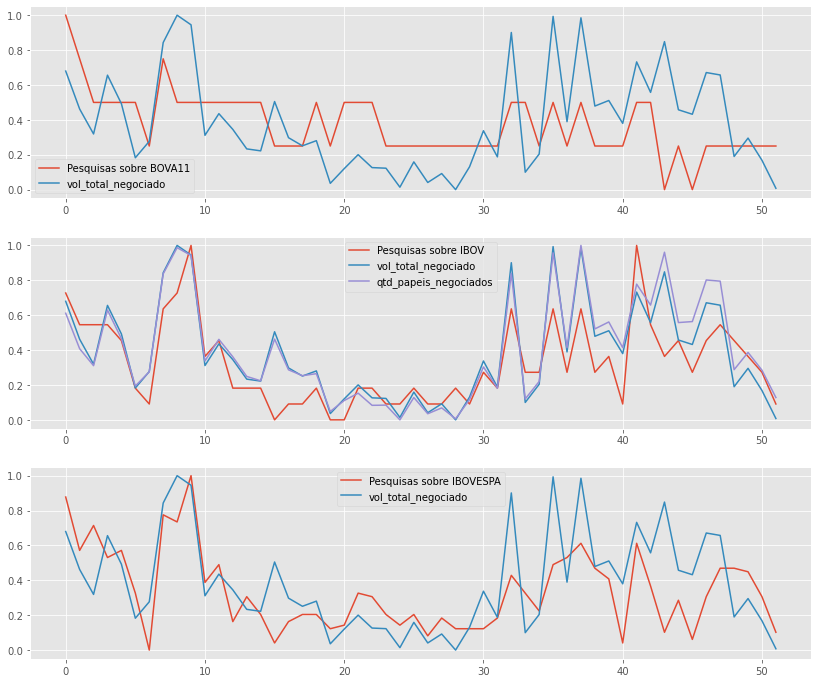

In [18]:
fig, axes = plt.subplots(nrows = 3, ncols = 1)

# 0.340834
trend_b3_scaled[['Pesquisas sobre BOVA11', 'vol_total_negociado']].plot(ax=axes[0], figsize=(14, 12))

# 0.801764 e 0.789732
trend_b3_scaled[['Pesquisas sobre IBOV', 'vol_total_negociado', 'qtd_papeis_negociados']].plot(ax=axes[1], figsize=(14, 12))

# 0.544032
trend_b3_scaled[['Pesquisas sobre IBOVESPA', 'vol_total_negociado']].plot(ax=axes[2], figsize=(14, 12))

aparentemente, tanto pelo valor de correlação quanto pela análise do gráfico, o ideal seria o termo "IBOV" e o volume total negociado